In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # Required for Colab
from skimage import measure
from skimage.filters import sobel, roberts
import PIL
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# File path to the image
Test_img_path = "/content/drive/MyDrive/DatasetBankNote/bangla_banknote_v2/Testing"
Train_img_path = "/content/drive/MyDrive/DatasetBankNote/bangla_banknote_v2/Training"

categories = ['1', '10', '100', '1000', '2', '20', '5', '50', '500']

# Preporcessing

In [ ]:
def preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply median blur for denoising
    denoised_image = cv2.medianBlur(gray_image, 3)

    # Apply Sobel filter for edge detection
    sobel_x = cv2.Sobel(denoised_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(denoised_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    histogram, _ = np.histogram(sobel_combined, bins=256, range=(0, 256))

    # Find a valley or peak in the histogram for thresholding
    # You can adjust this threshold selection method based on your images
    threshold_value = np.argmax(histogram[50:]) + 50

    # Apply binary thresholding
    _, binary_image = cv2.threshold(sobel_combined, threshold_value, 255, cv2.THRESH_BINARY)

    # Find contours using skimage
    contours = measure.find_contours(binary_image, 0.8)

    # Draw contours on the original image
    contour_image = np.copy(image)
    for contour in contours:
        contour = np.flip(contour, axis=1)  # skimage uses (row, column) coordinates
        cv2.polylines(contour_image, [contour.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)

    return contour_image

# Training

In [ ]:
# Preprocess Training Images and store them in a numpy array
training_images = []
training_labels = []
for category in categories:
    category_path = os.path.join(Train_img_path, category)

    for image_filename in os.listdir(category_path):
        image_path = os.path.join(category_path, image_filename)

         # Check if the image format is supported (e.g., 'jpg', 'jpeg', 'png')
        supported_formats = ('.jpg', '.jpeg', '.png')
        if image_path.lower().endswith(supported_formats):

            # Apply preprocessing to the image
            preprocessed_image = preprocess_image(image_path)

            # Append the preprocessed image and its label to the arrays
            training_images.append(preprocessed_image)
            training_labels.append(categories.index(category))

# Convert lists to numpy arrays
training_images = np.array(training_images)
training_labels = np.array(training_labels)

In [ ]:
# Feature vectors (flattened image features) and labels
X = training_images.reshape(len(training_images), -1)
y = training_labels

In [ ]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Using Random forest
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train, y_train)

# Predictions on the test set
y_pred = RFC.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=categories)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9298780487804879
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.90      0.95        20
          10       0.93      0.93      0.93        46
         100       0.91      0.98      0.94        50
        1000       0.98      1.00      0.99        42
           2       0.89      1.00      0.94        40
          20       0.93      0.90      0.92        30
           5       0.97      0.85      0.91        41
          50       0.89      0.85      0.87        39
         500       0.90      0.90      0.90        20

    accuracy                           0.93       328
   macro avg       0.93      0.92      0.93       328
weighted avg       0.93      0.93      0.93       328



In [ ]:
from sklearn.naive_bayes import GaussianNB


GNB = GaussianNB()
GNB.fit(X_train, y_train)

# Predictions on the test set
nb_y_pred = GNB.predict(X_test)

# Evaluate the Naive Bayes model
GNB_accuracy = accuracy_score(y_test, nb_y_pred)
GNB_report = classification_report(y_test, nb_y_pred, target_names=categories)

print("Naive Bayes Accuracy:", GNB_accuracy)
print("Naive Bayes Classification Report:\n", GNB_report)

Naive Bayes Accuracy: 0.6798780487804879
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.85      0.85        20
          10       0.44      0.74      0.55        46
         100       0.97      0.70      0.81        50
        1000       0.86      0.90      0.88        42
           2       0.83      0.47      0.60        40
          20       0.77      0.67      0.71        30
           5       0.46      0.51      0.48        41
          50       0.77      0.62      0.69        39
         500       0.60      0.75      0.67        20

    accuracy                           0.68       328
   macro avg       0.73      0.69      0.69       328
weighted avg       0.73      0.68      0.69       328



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors
KNN.fit(X_train, y_train)

# Predictions on the test set
knn_y_pred = KNN.predict(X_test)

# Evaluate the k-NN model
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_report = classification_report(y_test, knn_y_pred, target_names=categories)

print("k-NN Accuracy:", knn_accuracy)
print("k-NN Classification Report:\n", knn_report)

k-NN Accuracy: 0.9054878048780488
k-NN Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.95      0.97        20
          10       0.97      0.78      0.87        46
         100       0.79      0.92      0.85        50
        1000       0.92      0.86      0.89        42
           2       1.00      1.00      1.00        40
          20       0.75      1.00      0.86        30
           5       0.95      0.85      0.90        41
          50       1.00      0.92      0.96        39
         500       0.86      0.95      0.90        20

    accuracy                           0.91       328
   macro avg       0.92      0.92      0.91       328
weighted avg       0.92      0.91      0.91       328



In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Predict the classes on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)



In [ ]:

report = classification_report(y_test, y_pred, target_names=categories)
print("SVM Accuracy:", accuracy)
print("SVM Classification Report:\n", report)

SVM Accuracy: 0.9878048780487805
SVM Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.95      0.97        20
          10       0.98      0.98      0.98        46
         100       1.00      0.98      0.99        50
        1000       0.95      1.00      0.98        42
           2       1.00      1.00      1.00        40
          20       0.97      1.00      0.98        30
           5       1.00      0.98      0.99        41
          50       1.00      1.00      1.00        39
         500       1.00      1.00      1.00        20

    accuracy                           0.99       328
   macro avg       0.99      0.99      0.99       328
weighted avg       0.99      0.99      0.99       328



# Preprocessing Showcase

In [ ]:
image = cv2.imread('/content/drive/MyDrive/DatasetBankNote/bangla_banknote_v2/Training/5/5_102.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply median blur for denoising
denoised_image = cv2.medianBlur(gray_image, 3)

# Apply Sobel filter
sobel_x = cv2.Sobel(denoised_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(denoised_image, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobel_x, sobel_y)
histogram, _ = np.histogram(sobel_combined, bins=256, range=(0, 256))

# Find a valley or peak in the histogram for thresholding
# You can adjust this threshold selection method based on your images
threshold_value = np.argmax(histogram[50:]) + 50

# Apply binary thresholding
_, binary_image = cv2.threshold(sobel_combined, threshold_value, 255, cv2.THRESH_BINARY)

# Find contours using skimage
contours = measure.find_contours(binary_image, 0.8)

# Draw contours on the original image
contour_image = np.copy(image)
for contour in contours:
    contour = np.flip(contour, axis=1)  # skimage uses (row, column) coordinates
    cv2.polylines(contour_image, [contour.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)

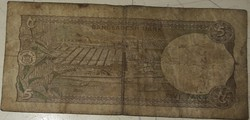

In [ ]:
cv2_imshow(image)

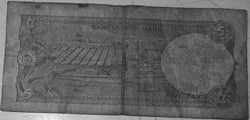

In [ ]:
cv2_imshow(gray_image)

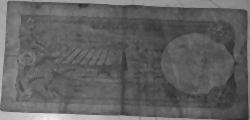

In [ ]:
cv2_imshow(denoised_image)

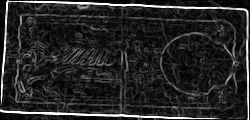

In [ ]:
cv2_imshow(sobel_combined)

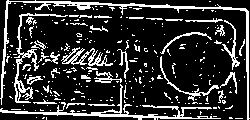

In [ ]:
cv2_imshow(binary_image)

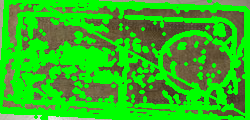

In [ ]:
cv2_imshow(contour_image)

# Prediction Phase

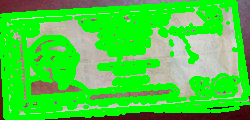

In [ ]:
input_image_path = "/content/drive/MyDrive/DatasetBankNote/bangla_banknote_v2/Training/5/5_100.jpg"  # Replace with the actual path
preprocessed_input = preprocess_image(input_image_path)

cv2_imshow(preprocessed_input)

flattened_input = preprocessed_input.reshape(1, -1)

In [ ]:
predicted_label = RFC.predict(flattened_input)[0]
predicted_category = categories[predicted_label]

print("Predicted Banknote Category Using Random Forest Classification:", predicted_category)

Predicted Banknote Category Using Random Forest Classification: 5


In [ ]:
pre_label = svm_classifier.predict(flattened_input)[0]
pre_category = categories[pre_label]

print("Predicted Banknote Category Using Support Vector Classification:", pre_category)

Predicted Banknote Category Using Support Vector Classification: 5


# Extra

(120, 250, 3)


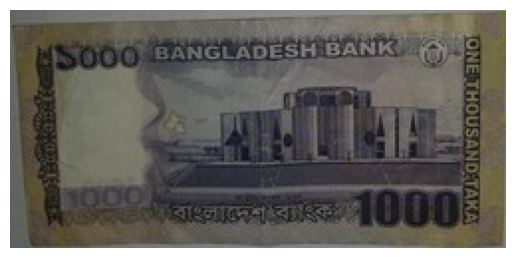

In [ ]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# reading the image
img = imread('/content/drive/MyDrive/DatasetBankNote/bangla_banknote_v2/Training/1000/1000_10.jpg')
plt.axis("off")
plt.imshow(img)
print(img.shape)

<ipython-input-48-5d2ff7d9d2d4>:2: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),


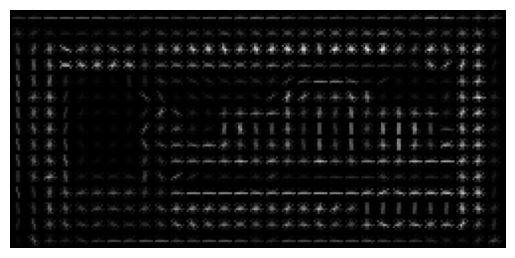

In [ ]:
#creating hog features
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")